In [2]:
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torch
import torchvision
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [3]:
dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]

In [11]:
type(events)

numpy.ndarray

In [12]:
events

array([( 0, 30,   1213, 1), ( 9, 18,   4044, 0), (30, 15,   4104, 1), ...,
       ( 9, 17, 301658, 0), (18,  8, 305112, 1), (19, 26, 309976, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

In [13]:
events.shape

(3913,)

In [4]:
events.dtype

dtype([('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

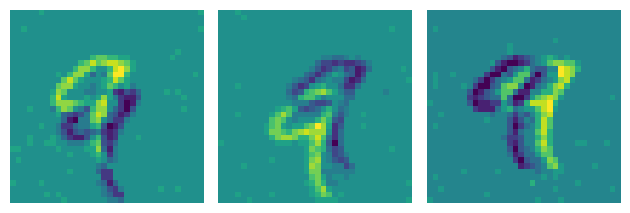

In [5]:
tonic.utils.plot_event_grid(events)

In [6]:
sensor_size = tonic.datasets.NMNIST.sensor_size
sensor_size

(34, 34, 2)

In [7]:


# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

In [9]:
frames = frame_transform(events)

In [10]:
frames.shape

(300, 2, 34, 34)

In [7]:
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [8]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [9]:
%timeit -o -r 10 load_sample_batched()

3.99 ms ± 415 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 3.99 ms ± 415 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [10]:
transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [11]:
event_tensor, target = next(iter(trainloader))
event_tensor.shape

torch.Size([308, 32, 2, 34, 34])

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [13]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [15]:
num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 30.58
Accuracy: 0.00%

Epoch 0, Iteration 1 
Train Loss: 30.46
Accuracy: 12.50%

Epoch 0, Iteration 2 
Train Loss: 30.58
Accuracy: 12.50%

Epoch 0, Iteration 3 
Train Loss: 30.85
Accuracy: 3.12%

Epoch 0, Iteration 4 
Train Loss: 15.39
Accuracy: 6.25%

Epoch 0, Iteration 5 
Train Loss: 15.56
Accuracy: 15.62%

Epoch 0, Iteration 6 
Train Loss: 18.47
Accuracy: 18.75%

Epoch 0, Iteration 7 
Train Loss: 16.57
Accuracy: 15.62%

Epoch 0, Iteration 8 
Train Loss: 14.94
Accuracy: 28.12%

Epoch 0, Iteration 9 
Train Loss: 12.79
Accuracy: 25.00%

Epoch 0, Iteration 10 
Train Loss: 16.58
Accuracy: 15.62%

Epoch 0, Iteration 11 
Train Loss: 15.41
Accuracy: 9.38%

Epoch 0, Iteration 12 
Train Loss: 12.82
Accuracy: 12.50%

Epoch 0, Iteration 13 
Train Loss: 12.10
Accuracy: 15.62%

Epoch 0, Iteration 14 
Train Loss: 13.23
Accuracy: 25.00%

Epoch 0, Iteration 15 
Train Loss: 12.57
Accuracy: 28.12%

Epoch 0, Iteration 16 
Train Loss: 12.50
Accuracy: 15.62%

Epoch 0, It